In [ ]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#libraries for reading data and preprocessing
from PyPDF2 import PdfFileReader
import csv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import string
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#libraries for importing classifiers
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#libraries for analyzing performances
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EXTRACTING DATA FROM CSV AND PDF

In [ ]:
def pdf_to_csv(data_path,txt_path,csv_path,job):
  #extracting all the pdf files in a text file
  with open(txt_path,'w') as f:
    for file in os.scandir(data_path): #loop to get all pdf in a folder
      pdf = PdfFileReader(file.path)
      #print(file.path)
      for page_num in range(pdf.numPages): #loop to extract all the pages in single pdf
        #print(page_num)
        pageObj = pdf.getPage(page_num)

        try:
          txt = pageObj.extractText()
        except:
          pass
        else:
          f.write(txt)
          f.write("\n")
      f.write(''.center(1,'^')) #including ^ to mark the end of resume
      f.write("\n")
    f.close()


    #removing the unnecessary line breaks in the text file and saving it in the temporary file
    with open('/content/drive/MyDrive/temp.txt','w') as t,open(txt_path,'r') as r:
        lines=r.readlines()
        res = []
        for sub in lines:
          res.append(sub.replace("\n", ""))
        txt = ' '.join([str(elem) for elem in res])
        t.write(txt)
        t.close()
        r.close()

    #converting txt file into csv file
    with open('/content/drive/MyDrive/temp.txt','r') as t,open(csv_path,'w') as f:
      lines=t.readline()
      writer=csv.writer(f,delimiter=',')
      writer.writerow(('Category','Resume'))
      res=[]
      id=job
      for word in lines:
        if word!="^":
          res.append(word)
        else:
          txt=""
          for i in res:
            txt+=i
          writer.writerow((id, txt))
          res=[]
      t.close()
      f.close()


In [ ]:
#making a csv file for android app developer
data_path='/content/drive/MyDrive/Android'
txt_path='/content/drive/MyDrive/Androidappdeveloper.txt'
csv_path1='/content/drive/MyDrive/Android.csv'
pdf_to_csv(data_path,txt_path,csv_path1,'AndroidAppDeveloper')

In [ ]:
data_path='/content/drive/MyDrive/Data_science'
txt_path='/content/drive/MyDrive/Datascience.txt'
csv_path2='/content/drive/MyDrive/Datascience.csv'
pdf_to_csv(data_path,txt_path,csv_path2,'DataScientist')

In [ ]:
data_path='/content/drive/MyDrive/Software_developer'
txt_path='/content/drive/MyDrive/SoftwareDeveloper.txt'
csv_path3='/content/drive/MyDrive/SoftwareDeveloper.csv'
pdf_to_csv(data_path,txt_path,csv_path3,'SoftwareDeveloper')

In [ ]:
data_path='/content/drive/MyDrive/MechanicalEngineer'
txt_path='/content/drive/MyDrive/MechanicalEngineer.txt'
csv_path4='/content/drive/MyDrive/MechanicalEngineer.csv'
pdf_to_csv(data_path,txt_path,csv_path4,'MechanicalEngineer')

In [ ]:
csv_paths=[csv_path1,csv_path2,csv_path3,csv_path4]
df=pd.DataFrame()
for path in csv_paths:
  df_temp=pd.read_csv(path)
  df=df.append(df_temp,ignore_index=True)
df.head()

In [ ]:
#observation from kaggle dataset
df_kaggle=pd.read_csv('/content/drive/MyDrive/UpdatedResumeDataSet.csv')
df_kaggle.head()

DATA COUNT AND VISUALISATION

In [ ]:
def data_plot(df1,df2):
  f,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
  sns.countplot(y="Category", data=df1,ax=axes[0]).set(title='Collected data')
  sns.countplot(y="Category", data=df2,ax=axes[1]).set(title='Data from Kaggle')
  plt.tight_layout()


In [ ]:
def count_job(df1,df2):
  print("No of resumes collected in each category in pdf form")
  print(df1['Category'].value_counts())
  print("\n")
  print("No of resumes collected in each category from kaggle")
  print(df2['Category'].value_counts())

In [ ]:
count_job(df,df_kaggle)

No of resumes collected in each category in pdf form
SoftwareDeveloper      19
AndroidAppDeveloper    17
MechanicalEngineer     14
DataScientist          10
Name: Category, dtype: int64


No of resumes collected in each category from kaggle
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer         

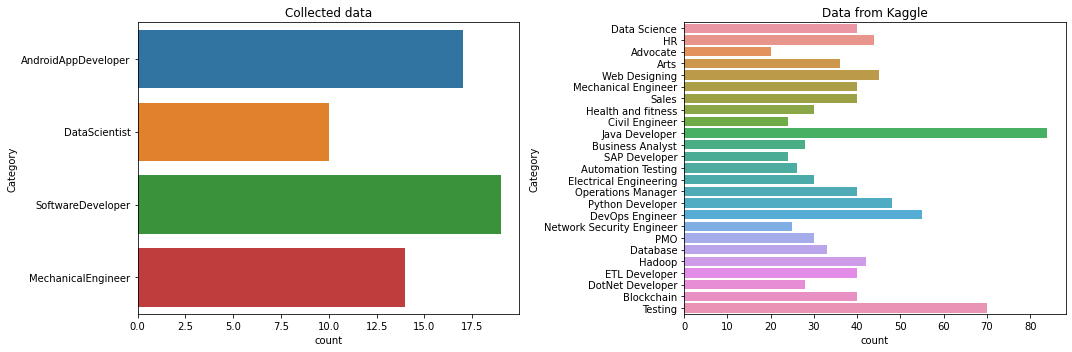

In [ ]:
data_plot(df,df_kaggle)

DATA CLEANING

In [ ]:
def cleanResume(description):
  description=re.sub("[a-z0-9\.\-+_\s]+@[a-z0-9\.\-+_\s]+\.[a-z\s]+",'', description) #finding all personal emailIDs
  description=re.sub("[a-z0-9\.\-+_\s]+@[a-z0-9\.\-+_\s]+\.[a-z\s]+\.[a-z\s]",'',description) #finding all domain emails
  description=re.sub("\(+\+[0-9]+\)",'',description)#removing all country codes of format(+**)
  description=re.sub("\+[0-9]",'',description)#removing all country codes of format +**
  description=re.sub(r'\d{10}','',description)#removing all phone numbers
  description=re.sub(r'http\S+\s','',description)#removing urls
  description=re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', description)#removing all special characters and punctions
  description=re.sub('\s+', ' ', description)  # remove extra whitespace
  description=re.sub('^\s+','',description)    #removing white space at the beginning of each resume
  description=re.sub('●','',description)      #removing '●'
  description=re.sub("\uf0b7",'',description) #removing '\uf0b7'
  description=re.sub("\u200b",'',description) #removing '\u200b'(zero width space)
  description=re.sub('â\x80¢','',description)#â\x80¢
  description=re.sub('•','',description) #removing '•'
  description=re.sub('–','',description) #removing '–'
  description=re.sub('’','',description) #removing ’
  return description

In [ ]:
df['cleaned_resume'] = df.Resume.apply(lambda x: cleanResume(x))
df_kaggle['cleaned_resume']=df_kaggle.Resume.apply(lambda x:cleanResume(x))

In [ ]:
df.head()

STOP WORDS AND TOKENISATION,

In [ ]:
def find_common_words(df1):
  stop_words =set(stopwords.words('english'))
  total=[]
  records=df1['Resume'].values
  cleaned_records=""
  for resume in records:
    clean_text=cleanResume(resume)
    cleaned_records+=clean_text
    requiredWords = nltk.word_tokenize(clean_text)
    for word in requiredWords:
      if word not in stop_words and word not in string.punctuation:
        total.append(word)
  wordfreqdist=nltk.FreqDist(total)
  common=wordfreqdist.most_common(100)
  print(common)
  return common,cleaned_records


In [ ]:
def label_encode(df1):
  label_encode = preprocessing.LabelEncoder()
  df1['Category']=label_encode.fit_transform(df1['Category'])
  df1['Category'].value_counts()
  return df1['Category']

In [ ]:
common1,clean_words1=find_common_words(df)
common2,clean_words2=find_common_words(df_kaggle)


[('Android', 108), ('app', 59), ('using', 41), ('Development', 36), ('Developer', 33), ('A', 31), ('App', 31), ('application', 30), ('project', 29), ('2019', 27), ('e', 27), ('I', 27), ('development', 26), ('C', 26), ('2021', 26), ('Application', 24), ('School', 24), ('2', 24), ('India', 24), ('r', 24), ('Tech', 22), ('Puducherry', 22), ('2017', 22), ('1', 22), ('2020', 21), ('new', 21), ('Java', 20), ('Worked', 20), ('data', 19), ('Technology', 19), ('android', 19), ('team', 19), ('2018', 19), ('mobile', 19), ('Mobile', 19), ('Firebase', 19), ('\uf0d8', 19), ('Engineering', 18), ('Data', 18), ('Software', 18), ('code', 18), ('circle', 18), ('Kotlin', 18), ('Computer', 17), ('Web', 17), ('—', 17), ('Work', 17), ('Python', 16), ('Science', 15), ('technical', 15), ('end', 15), ('Lead', 15), ('0', 15), ('Project', 15), ('MVVM', 15), ('experience', 14), ('Present', 14), ('CGPA', 14), ('Secondary', 14), ('implementation', 14), ('c', 14), ('learning', 13), ('time', 13), ('various', 13), ('Go

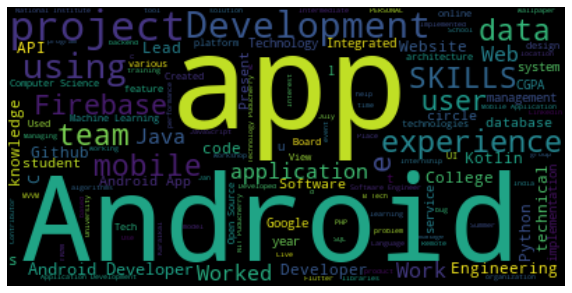

In [ ]:
data_Android=pd.read_csv(csv_path1)
common,cleaned_record=find_common_words(data_Android)
wc = WordCloud().generate(cleaned_record)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

[('I', 34), ('2020', 30), ('using', 24), ('Python', 23), ('data', 23), ('Machine', 22), ('Learning', 22), ('project', 22), ('\uf0d8', 22), ('learning', 21), ('2019', 21), ('2021', 20), ('A', 20), ('·', 19), ('app', 16), ('Data', 15), ('—', 15), ('C', 14), ('10', 13), ('model', 13), ('2017', 12), ('CGPA', 12), ('Puducherry', 11), ('Technology', 11), ('system', 11), ('NITPY', 10), ('machine', 10), ('used', 10), ('performance', 10), ('Computer', 9), ('National', 9), ('Science', 9), ('NLP', 9), ('Project', 9), ('like', 9), ('Intern', 9), ('new', 9), ('python', 9), ('The', 9), ('It', 9), ('skills', 8), ('2015', 8), ('models', 8), ('May', 8), ('School', 8), ('SKILLS', 8), ('Programming', 8), ('Secured', 8), ('quality', 8), ('based', 8), ('NIT', 8), ('Github', 8), ('Android', 8), ('Worked', 8), ('\uf0fc', 8), ('Institute', 7), ('OF', 7), ('Web', 7), ('course', 7), ('projects', 7), ('PROJECTS', 7), ('Java', 7), ('Development', 7), ('deep', 7), ('implemented', 7), ('experience', 7), ('ML', 7), 

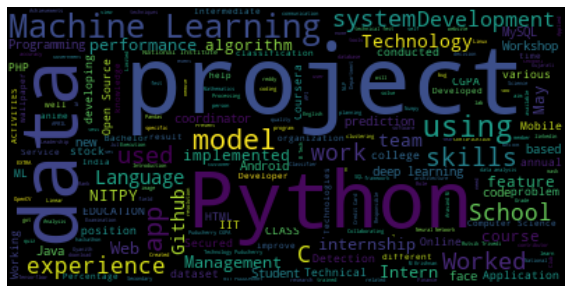

In [ ]:
data_scientist=pd.read_csv(csv_path2)
common,cleaned_record=find_common_words(data_scientist)
wc = WordCloud().generate(cleaned_record)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

[('Puducherry', 57), ('C', 53), ('2019', 43), ('2020', 40), ('2017', 37), ('Python', 37), ('NIT', 37), ('\uf064', 36), ('Institute', 34), ('Technology', 33), ('Data', 31), ('Web', 29), ('National', 27), ('using', 27), ('Computer', 27), ('project', 24), ('\uf076', 24), ('Development', 24), ('app', 24), ('skills', 23), ('8', 23), ('Science', 23), ('1', 23), ('Languages', 23), ('2021', 22), ('website', 22), ('B', 21), ('Java', 21), ('A', 21), ('School', 21), ('Engineering', 20), ('Intermediate', 20), ('development', 20), ('team', 20), ('Programming', 20), ('HTML', 20), ('I', 20), ('2015', 19), ('learning', 19), ('CGPA', 18), ('Machine', 18), ('Technical', 18), ('CSS', 18), ('9', 17), ('—', 17), ('SKILLS', 17), ('Attended', 17), ('workshop', 17), ('Worked', 17), ('7', 17), ('➔', 16), ('May', 16), ('Semester', 16), ('Member', 15), ('3', 15), ('Secondary', 15), ('fest', 15), ('English', 15), ('Developed', 15), ('knowledge', 14), ('Tech', 14), ('SQL', 14), ('management', 14), ('10', 14), ('20

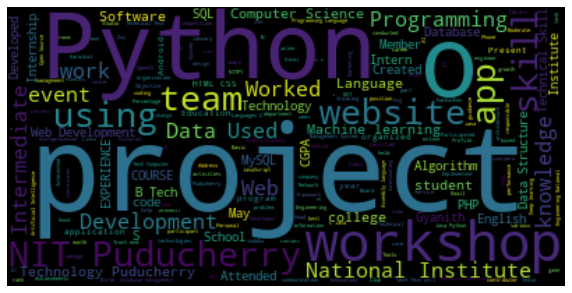

In [ ]:
data_software=pd.read_csv(csv_path3)
common,cleaned_record=find_common_words(data_software)
wc = WordCloud().generate(cleaned_record)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

[('Patna', 74), ('I', 55), ('E', 51), ('NIT', 48), ('A', 47), ('C', 46), ('S', 41), ('9', 39), ('R', 37), ('School', 36), ('O', 36), ('N', 36), ('2015', 34), ('e', 34), ('T', 31), ('”', 30), ('“', 27), ('India', 27), ('P', 26), ('B', 25), ('design', 22), ('knowledge', 22), ('Engineering', 22), ('Institute', 22), ('2014', 21), ('Mechanical', 20), ('2', 20), ('Technology', 19), ('8', 19), ('fest', 19), ('\uf020', 19), ('skills', 18), ('L', 18), ('2020', 16), ('National', 16), ('2012', 16), ('2nd', 16), ('Training', 16), ('\uf0d8', 16), ('H', 16), ('r', 16), ('1', 15), ('Board', 15), ('ASME', 15), ('3rd', 15), ('D', 15), ('Design', 14), ('Technical', 14), ('2019', 13), ('team', 13), ('The', 13), ('event', 13), ('Workshop', 13), ('prize', 13), ('best', 13), ('Class', 13), ('organization', 13), ('G', 13), ('n', 13), ('manufacturing', 12), ('working', 12), ('Education', 12), ('Tech', 12), ('CGPA', 12), ('Secondary', 12), ('training', 12), ('CBSE', 12), ('M', 12), ('4', 11), ('project', 11), 

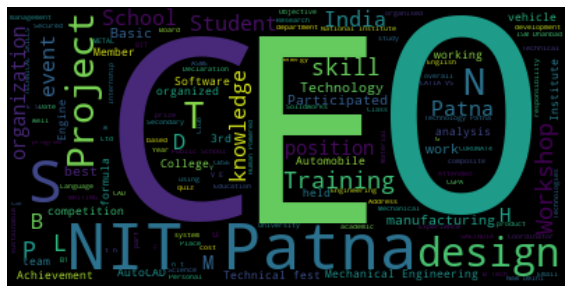

In [ ]:
data_ME=pd.read_csv(csv_path4)
common,cleaned_record=find_common_words(data_ME)
wc = WordCloud().generate(cleaned_record)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Data Science
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('expe

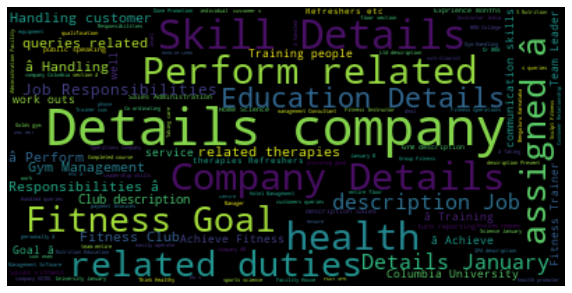

HR
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experience', 1

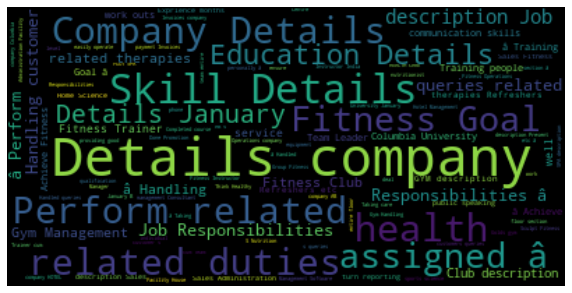

Advocate
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experien

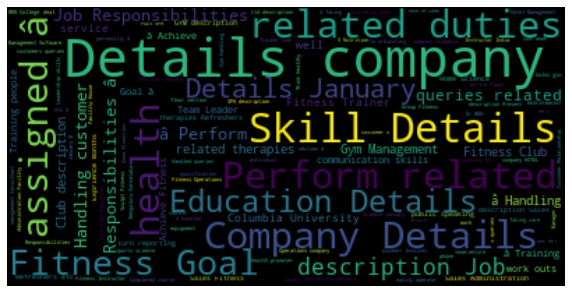

Arts
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experience',

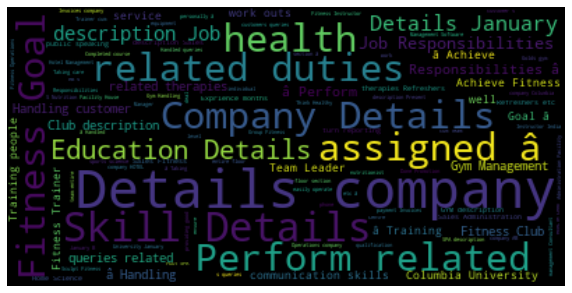

Web Designing
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('exp

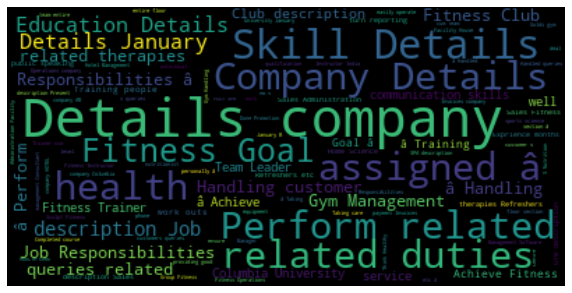

Mechanical Engineer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15),

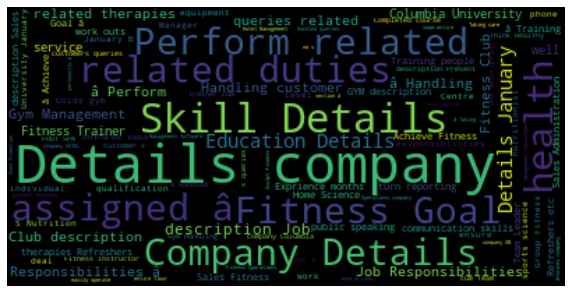

Sales
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experience'

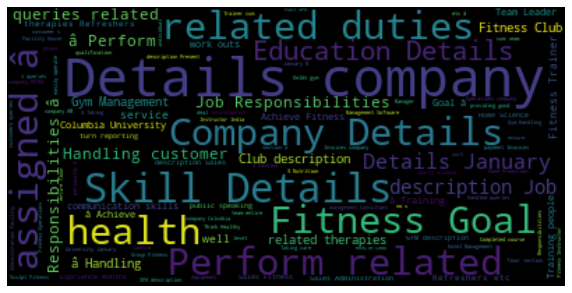

Health and fitness
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), 

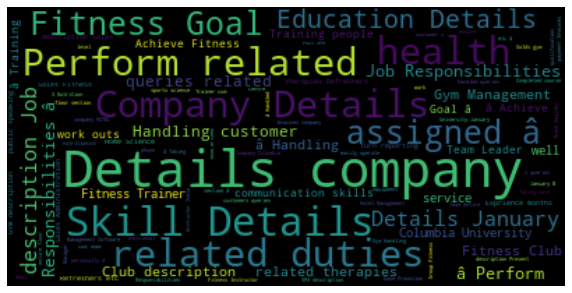

Civil Engineer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('ex

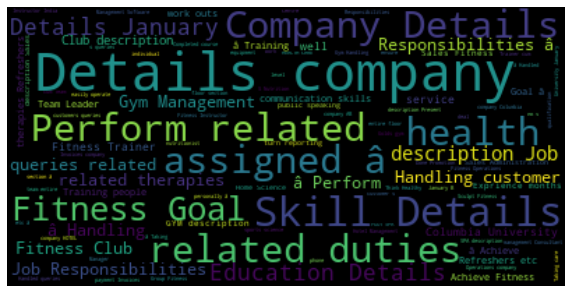

Java Developer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('ex

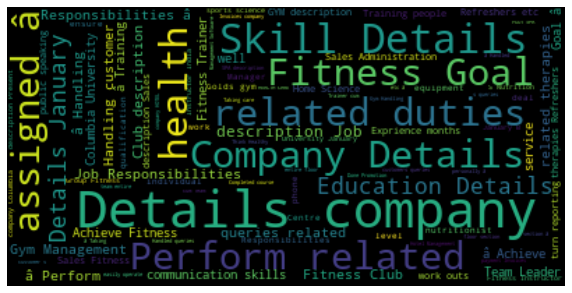

Business Analyst
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('

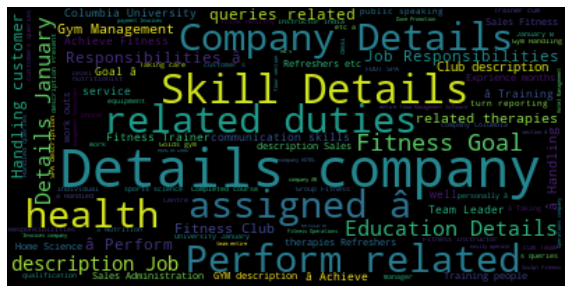

SAP Developer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('exp

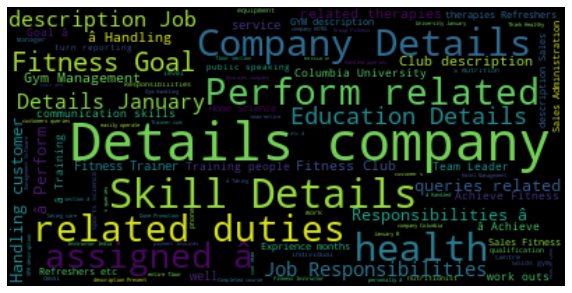

Automation Testing
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), 

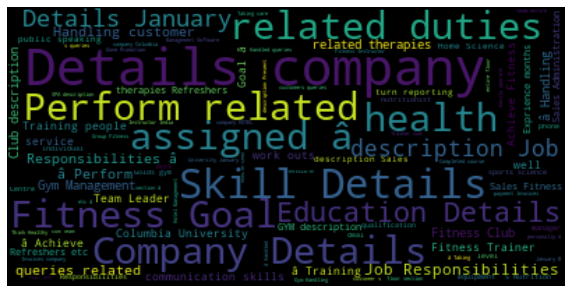

Electrical Engineering
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 1

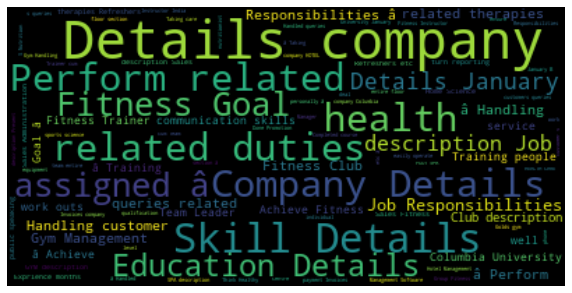

Operations Manager
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), 

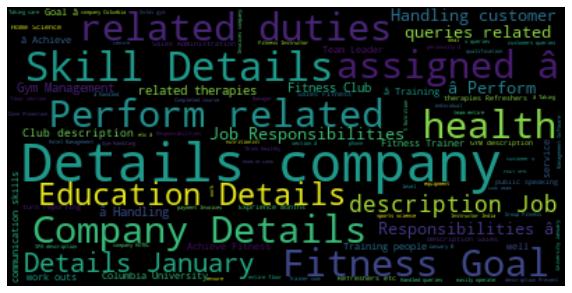

Python Developer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('

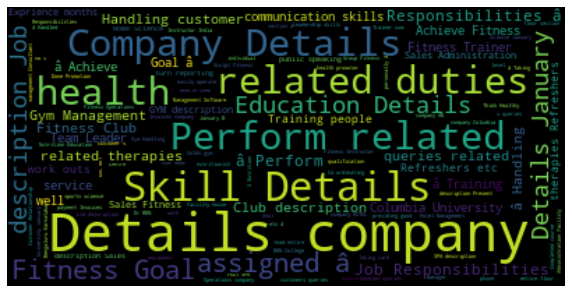

DevOps Engineer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('e

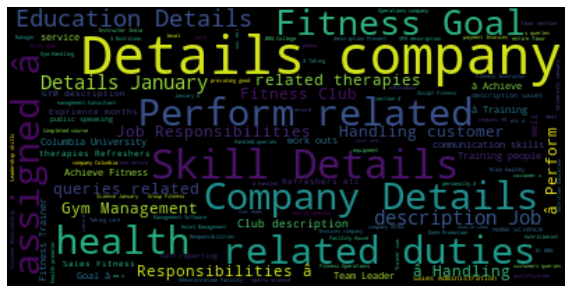

Network Security Engineer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To'

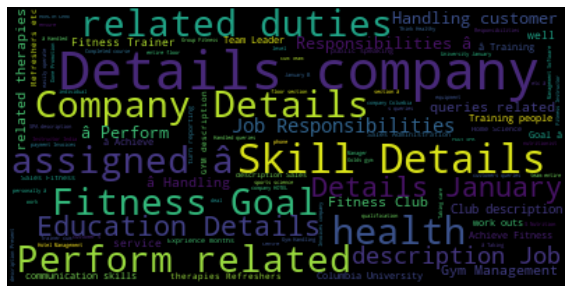

PMO
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experience', 

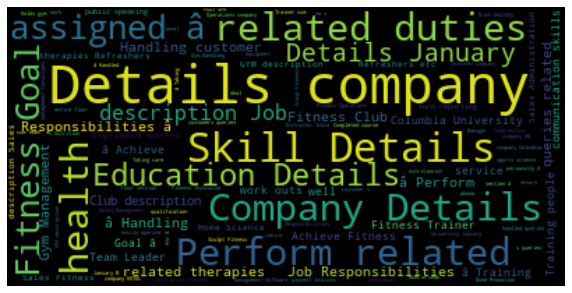

Database
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experien

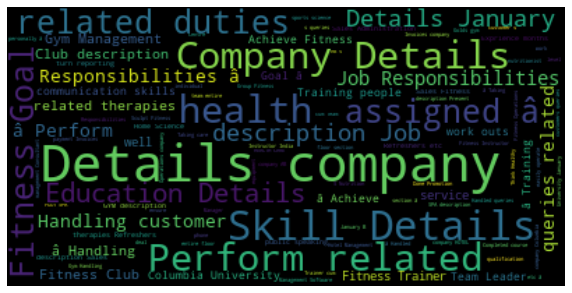

Hadoop
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experience

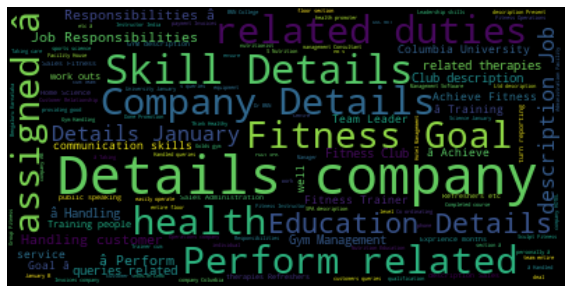

ETL Developer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('exp

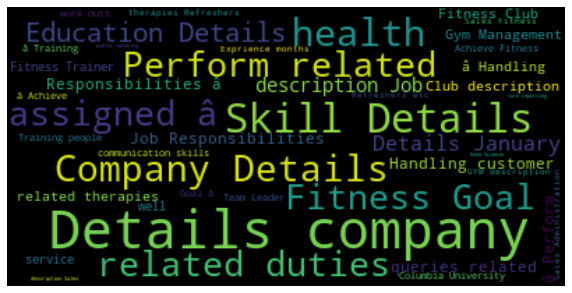

DotNet Developer
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('

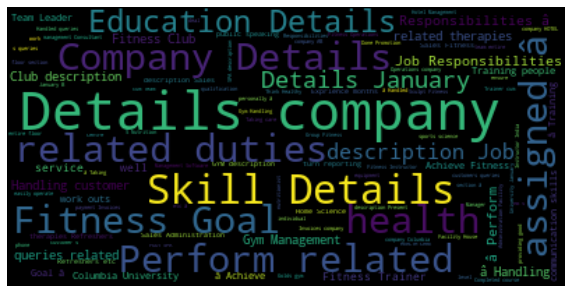

Blockchain
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experi

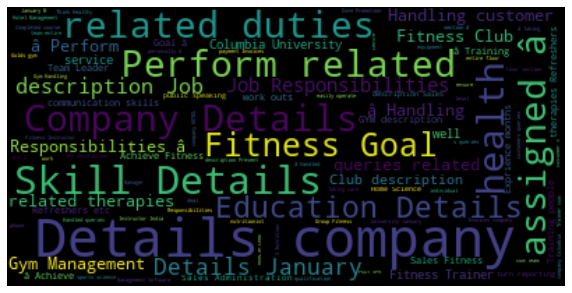

Testing
[('Fitness', 125), ('company', 115), ('description', 115), ('Details', 90), ('â\x9e¢', 90), ('fitness', 60), ('January', 50), ('health', 50), ('related', 45), ('Nutrition', 40), ('Gym', 40), ('Sales', 40), ('Education', 35), ('Science', 35), ('Handling', 35), ('queries', 35), ('Skill', 30), ('skills', 30), ('months', 30), ('Management', 30), ('work', 30), ('customers', 30), ('Centre', 30), ('high', 25), ('Company', 25), ('Responsibilities', 25), ('College', 25), ('University', 25), ('training', 25), ('Perform', 25), ('duties', 25), ('responsibilities', 25), ('assigned', 25), ('etc', 25), ('Health', 25), ('management', 25), ('activities', 25), ('Manager', 25), ('GOQii', 25), ('Skills', 20), ('Columbia', 20), ('nutrition', 20), ('people', 20), ('Team', 20), ('Job', 20), ('customer', 20), ('therapies', 20), ('team', 20), ('Exprience', 20), ('96', 20), ('Club', 20), ('reporting', 20), ('public', 20), ('Personal', 15), ('gym', 15), ('college', 15), ('3', 15), ('To', 15), ('experienc

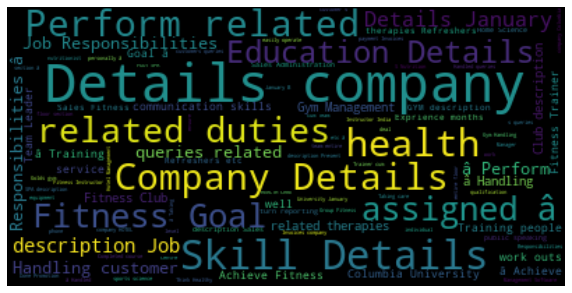

In [ ]:
l=df_kaggle['Category'].unique()
for i in range(0,len(l)):
  print(l[i])
  df2=df_kaggle[df_kaggle['Category']==l[7]]
  common,cleaned_record=find_common_words(df2)
  wc = WordCloud().generate(cleaned_record)
  plt.figure(figsize=(10,10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()


In [ ]:
df['Category']=label_encode(df)
df_kaggle['Category']=label_encode(df_kaggle)

In [ ]:
df['Category'].value_counts()

3    19
0    17
2    14
1    10
Name: Category, dtype: int64

In [ ]:
df_kaggle['Category'].value_counts()

15    84
23    70
8     55
20    48
24    45
12    44
13    42
3     40
10    40
18    40
6     40
22    40
16    40
1     36
7     33
11    30
14    30
19    30
4     28
9     28
2     26
17    25
21    24
5     24
0     20
Name: Category, dtype: int64

In [ ]:
df.head()

TEST AND TRAIN SPLIT

In [ ]:
def data_split(df1):
  Text=df1['cleaned_resume'].values
  Target=df1['Category'].values
  word_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
  word_vectorizer.fit(Text)
  WordFeatures = word_vectorizer.transform(Text)
  X_train,X_test,y_train,y_test = train_test_split(WordFeatures,Target,random_state=42, test_size=0.2,shuffle=True, stratify=Target)
  return X_train,X_test,y_train,y_test

In [ ]:
#split of collected data in PDF form
x_train1,x_test1,y_train1,y_test1=data_split(df)
print(x_train1.shape)
print(x_test1.shape)

(48, 4518)
(12, 4518)


In [ ]:
#split of data in csv form
x_train2,x_test2,y_train2,y_test2=data_split(df_kaggle)
print(x_train2.shape)
print(x_test2.shape)

(769, 7376)
(193, 7376)


KNN CLASSIFIER

In [ ]:
def build_KNN(x_train,x_test,y_train,y_test):
  clf = OneVsRestClassifier(KNeighborsClassifier())
  clf.fit(x_train, y_train)
  prediction = clf.predict(x_test)
  print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(x_train, y_train)))
  print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))
  print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction, zero_division=1)))
  print("\n Confusion matrix\n %s"%(confusion_matrix(y_test,prediction)))


In [ ]:
build_KNN(x_train1,x_test1,y_train1,y_test1)

Accuracy of KNeighbors Classifier on training set: 0.81
Accuracy of KNeighbors Classifier on test set: 0.92

 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      0.75      0.86         4

    accuracy                           0.92        12
   macro avg       0.94      0.94      0.93        12
weighted avg       0.94      0.92      0.92        12



 Confusion matrix
 [[3 0 0 0]
 [0 2 0 0]
 [0 0 3 0]
 [1 0 0 3]]


In [ ]:
build_KNN(x_train2,x_test2,y_train2,y_test2)

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set: 0.98

 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       0.75      0.60      0.67         5
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       0.89      1.00      0.94         8
           7       1.00      0.86      0.92         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         8
          11       0.86      1.00      0.92         6
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.

NAIVE BAYES

In [ ]:
def build_NB(x_train,x_test,y_train,y_test):
  clf = OneVsRestClassifier(MultinomialNB())
  clf.fit(x_train, y_train)
  prediction = clf.predict(x_test)
  print('Accuracy of  NaiveBayes Classifier on training set: {:.2f}'.format(clf.score(x_train, y_train)))
  print('Accuracy of NaiveBayes Classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))
  print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction,zero_division=1)))
  print("\n Confusion matrix\n %s"%(confusion_matrix(y_test,prediction)))


In [ ]:
build_NB(x_train1,x_test1,y_train1,y_test1)

Accuracy of  NaiveBayes Classifier on training set: 0.96
Accuracy of NaiveBayes Classifier on test set: 0.67

 Classification report for classifier OneVsRestClassifier(estimator=MultinomialNB()):
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       1.00      0.00      0.00         2
           2       1.00      1.00      1.00         3
           3       0.50      0.75      0.60         4

    accuracy                           0.67        12
   macro avg       0.79      0.60      0.57        12
weighted avg       0.75      0.67      0.62        12



 Confusion matrix
 [[2 0 0 1]
 [0 0 0 2]
 [0 0 3 0]
 [1 0 0 3]]


In [ ]:
build_NB(x_train2,x_test2,y_train2,y_test2)

Accuracy of  NaiveBayes Classifier on training set: 1.00
Accuracy of NaiveBayes Classifier on test set: 0.99

 Classification report for classifier OneVsRestClassifier(estimator=MultinomialNB()):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      0.60      0.75         5
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00    

DECISION TREE


In [ ]:
def build_tree(x_train,x_test,y_train,y_test):
  clf = OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy'))
  clf.fit(x_train, y_train)
  prediction = clf.predict(x_test)
  print('Accuracy of  Decision Tree Classifier on training set: {:.2f}'.format(clf.score(x_train, y_train)))
  print('Accuracy of Decision Tree Classifier on test set: {:.2f}'.format(clf.score(x_test, y_test)))
  print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction,zero_division=1)))
  print("\n Confusion matrix\n %s"%(confusion_matrix(y_test,prediction)))

In [ ]:
build_tree(x_train1,x_test1,y_train1,y_test1)

Accuracy of  Decision Tree Classifier on training set: 0.98
Accuracy of Decision Tree Classifier on test set: 0.67

 Classification report for classifier OneVsRestClassifier(estimator=DecisionTreeClassifier(criterion='entropy')):
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         3
           3       0.50      0.75      0.60         4

    accuracy                           0.67        12
   macro avg       0.62      0.60      0.60        12
weighted avg       0.67      0.67      0.65        12



 Confusion matrix
 [[2 0 0 1]
 [0 0 0 2]
 [0 0 3 0]
 [0 1 0 3]]


In [ ]:
build_tree(x_train2,x_test2,y_train2,y_test2)

Accuracy of  Decision Tree Classifier on training set: 1.00
Accuracy of Decision Tree Classifier on test set: 0.99

 Classification report for classifier OneVsRestClassifier(estimator=DecisionTreeClassifier(criterion='entropy')):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         9
          13 